# [NOT WORKING] Exploration of Collider Bias with discrete Bayes Nets using `bnlearn`

[Collider bias](https://en.wikipedia.org/wiki/Collider_(statistics) ) can be seen as a form of selection bias. In a causal network, if we have the structure `A -> Collider <- B`, then "conditioning on the collider opens the path between A and B [which can] introduce bias when estimating the causal association between A and B, potentially introducing associations where there are none."

In [1]:
import bnlearn
from pgmpy.factors.discrete import TabularCPD

[BNLEARN] Error: Matplotlib version is advised to be to be > v3.1.1.
Try to: pip install -U matplotlib


## check it works with example from the docs

In [2]:
# Define the network structure
edges = [('Cloudy', 'Sprinkler'),
         ('Cloudy', 'Rain'),
         ('Sprinkler', 'Wet_Grass'),
         ('Rain', 'Wet_Grass')]

# Make the actual Bayesian DAG
DAG = bnlearn.make_DAG(edges)

[BNLEARN] Bayesian DAG created.


[BNLEARN][plot] Making plot based on BayesianModel


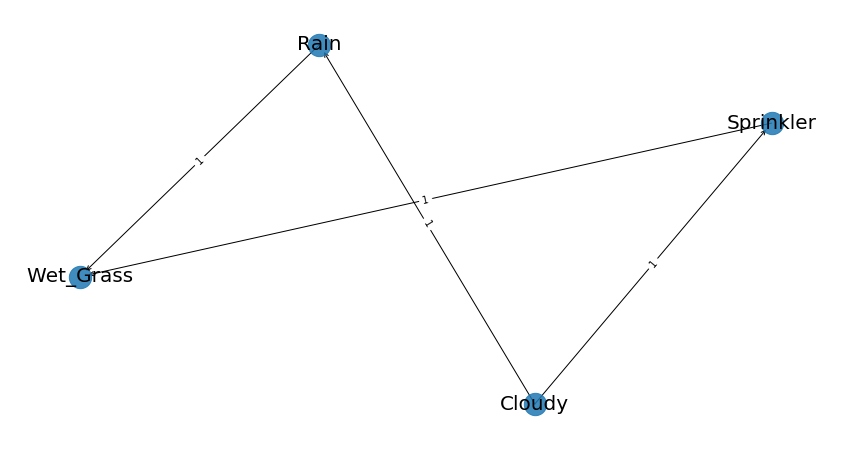

{'pos': {'Cloudy': array([ 0.30671808, -1.        ]),
  'Sprinkler': array([0.97710481, 0.4639026 ]),
  'Rain': array([-0.30268204,  0.87271201]),
  'Wet_Grass': array([-0.98114085, -0.33661461])},
 'G': <networkx.classes.digraph.DiGraph at 0x109d1fad0>}

In [3]:
bnlearn.plot(DAG)

In [4]:
cpt_cloudy = TabularCPD(variable='Cloudy', variable_card=2, values=[[0.5], [0.5]])

cpt_sprinkler = TabularCPD(variable='Sprinkler', variable_card=2,
                           values=[[0.5, 0.9],
                                   [0.5, 0.1]],
                           evidence=['Cloudy'], evidence_card=[2])
# Rain
cpt_rain = TabularCPD(variable='Rain', variable_card=2,
                      values=[[0.8, 0.2],
                              [0.2, 0.8]],
                      evidence=['Cloudy'], evidence_card=[2])

# Wet Grass
cpt_wet_grass = TabularCPD(variable='Wet_Grass', variable_card=2,
                           values=[[1, 0.1, 0.1, 0.01],
                                   [0, 0.9, 0.9, 0.99]],
                           evidence=['Sprinkler', 'Rain'],
                           evidence_card=[2, 2])

In [5]:
DAG = bnlearn.make_DAG(DAG, CPD=[cpt_cloudy, cpt_sprinkler, cpt_rain, cpt_wet_grass])

[BNLEARN] No changes made to existing Bayesian DAG.
[BNLEARN] Add CPD: Cloudy
[BNLEARN] Add CPD: Sprinkler
[BNLEARN] Add CPD: Rain
[BNLEARN] Add CPD: Wet_Grass
[BNLEARN.print_CPD] Model correct: True


In [6]:
DAG = bnlearn.print_CPD(DAG)

[BNLEARN.print_CPD] Independencies:
(Cloudy _|_ Wet_Grass | Rain, Sprinkler)
(Sprinkler _|_ Rain | Cloudy)
(Rain _|_ Sprinkler | Cloudy)
(Wet_Grass _|_ Cloudy | Rain, Sprinkler)
[BNLEARN.print_CPD] Nodes: ['Cloudy', 'Sprinkler', 'Rain', 'Wet_Grass']
[BNLEARN.print_CPD] Edges: [('Cloudy', 'Sprinkler'), ('Cloudy', 'Rain'), ('Sprinkler', 'Wet_Grass'), ('Rain', 'Wet_Grass')]
CPD of Cloudy:
+-----------+-----+
| Cloudy(0) | 0.5 |
+-----------+-----+
| Cloudy(1) | 0.5 |
+-----------+-----+
CPD of Sprinkler:
+--------------+-----------+-----------+
| Cloudy       | Cloudy(0) | Cloudy(1) |
+--------------+-----------+-----------+
| Sprinkler(0) | 0.5       | 0.9       |
+--------------+-----------+-----------+
| Sprinkler(1) | 0.5       | 0.1       |
+--------------+-----------+-----------+
CPD of Rain:
+---------+-----------+-----------+
| Cloudy  | Cloudy(0) | Cloudy(1) |
+---------+-----------+-----------+
| Rain(0) | 0.8       | 0.2       |
+---------+-----------+-----------+
| Rain(1) | 0

In [7]:
q1 = bnlearn.inference.fit(DAG, variables=['Wet_Grass'], evidence={'Rain':1, 'Sprinkler':0, 'Cloudy':1})


[BNLEARN][inference] Variable Elimination..


TypeError: 'NoneType' object is not subscriptable

# Example 2: Does collider bias make it look like nicotine is protective of COVID

![](img/bayes_net_1.png)

Here we have a prior probability of 25% of being a smoker. **Independently**, there is a 10% prior probability of having Covid-19. The vector `[0.9, 0.1, 0.9, 0.01]` specifies the probability of being in hospital as a function of smoking and covid status:

- smoking, covid. High probability of being in hospital.
- smoking, ¬covid. Moderate probability of being in hospital
- ¬smoking, covid. High probability of being in hospital
- ¬smoking, ¬covid. Low probability of being in hospital

One of the key points here is that of people who do not have covid, smokers are expected to have a higher probability of being in hospital than non-smokers.

[BNLEARN] Bayesian DAG created.
[BNLEARN][plot] Making plot based on BayesianModel


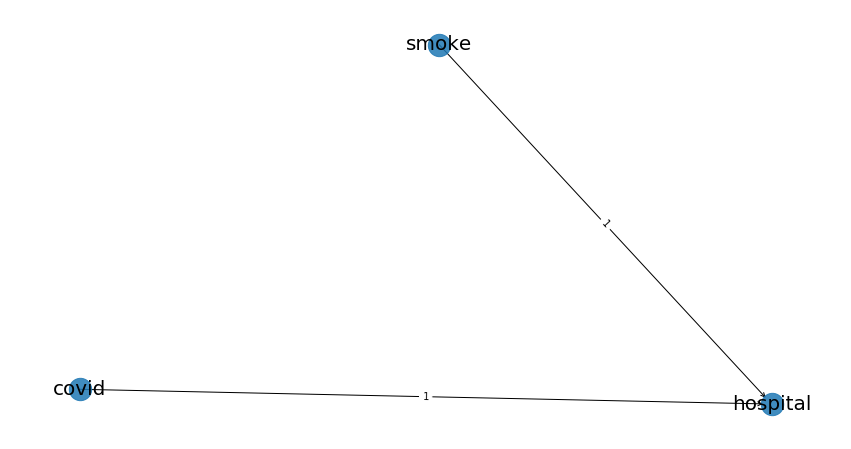

{'pos': {'smoke': array([0.02566957, 0.90328408]),
  'hospital': array([ 0.97433043, -0.48006166]),
  'covid': array([-1.        , -0.42322242])},
 'G': <networkx.classes.digraph.DiGraph at 0x1c24a3a290>}

In [8]:
edges = [('smoke', 'hospital'),
         ('covid', 'hospital')]

DAG = bnlearn.make_DAG(edges)

bnlearn.plot(DAG)

In [9]:
cpd_a = TabularCPD('smoke', 2, 
                   [[0.25, 0.75]], 
                   state_names={'smoke': ['yes', 'no']})

cpd_b = TabularCPD('covid', 2, 
                   [[0.1, 0.9]], 
                   state_names={'covid': ['yes', 'no']})

cpd_collider = TabularCPD('hospital', 2, 
                          [[0.9, 0.1, 0.9, 0.01], 
                           [0.1, 0.9, 0.1, 0.99]],
                          evidence=['smoke','covid'],
                          evidence_card=[2,2], 
                          state_names={'hospital': ['yes', 'no'], 
                                       'smoke': ['yes', 'no'], 
                                       'covid': ['yes', 'no']})

In [10]:
DAG = bnlearn.make_DAG(DAG, CPD=[cpd_a, cpd_b, cpd_collider])

[BNLEARN] No changes made to existing Bayesian DAG.
[BNLEARN] Add CPD: smoke
[BNLEARN] Add CPD: covid
[BNLEARN] Add CPD: hospital
[BNLEARN.print_CPD] Model correct: True


In [11]:
DAG = bnlearn.print_CPD(DAG)

[BNLEARN.print_CPD] Independencies:
(smoke _|_ covid)
(covid _|_ smoke)
[BNLEARN.print_CPD] Nodes: ['smoke', 'hospital', 'covid']
[BNLEARN.print_CPD] Edges: [('smoke', 'hospital'), ('covid', 'hospital')]
CPD of smoke:
+------------+------+
| smoke(yes) | 0.25 |
+------------+------+
| smoke(no)  | 0.75 |
+------------+------+
CPD of covid:
+------------+-----+
| covid(yes) | 0.1 |
+------------+-----+
| covid(no)  | 0.9 |
+------------+-----+
CPD of hospital:
+---------------+------------+------------+------------+-----------+
| smoke         | smoke(yes) | smoke(yes) | smoke(no)  | smoke(no) |
+---------------+------------+------------+------------+-----------+
| covid         | covid(yes) | covid(no)  | covid(yes) | covid(no) |
+---------------+------------+------------+------------+-----------+
| hospital(yes) | 0.9        | 0.1        | 0.9        | 0.01      |
+---------------+------------+------------+------------+-----------+
| hospital(no)  | 0.1        | 0.9        | 0.1      

In [12]:
bnlearn.print_CPD(DAG)


AttributeError: 'NoneType' object has no attribute 'get_cpds'

### Sanity check
Probability you have covid depending on if you are a smoker or non-smoker. These should be equal as our Bayes Net specifies that smoking and covid are independent.

In [18]:
beliefs = bnlearn.inference.fit(DAG, 
                                variables=['hospital'], 
                                evidence={'smoke': 'yes'})

[BNLEARN][inference] Variable Elimination..


TypeError: 'NoneType' object is not subscriptable

### Calculate P(covid|smoking, hospital) and P(covid|¬smoking, hospital)

If you condition upon being in hospital (ie only observer people who are in hospital), then it might be that we see different probabilities of having covid based on whether you smoke or not.

In [ ]:
model.predict_proba({'smokeD': 'yes', 'hospitalD': 'yes'})

In [ ]:
model.predict_proba({'smokeD': 'no', 'hospitalD': 'yes'})

Confirmed.

Boom! There we have it. There is a _higher_ chance that you will have Covid-19 if you are a _non-smoker_ in hospital, then if you are a smoker in hospital. And this result is produced by a Bayesian Net which explicitly states that having covid is statistically independent from being a smoker.

This is not necessarily proof that nicotine is useless against covid. But it does show that somewhat perplexing epidemiological results should not be taken as sufficient evidence that nicotine is protective against covid.